## Building a First Model
- In the last notebook / lesson we loaded in the data from retrosheet and did some processing to get the team level statistics.
- We saved that data to a file called 'df_bp1.csv'
- In this notebook, we will load in that data, do some initital data exploration, and then build and evaluate our first predictive model 

In [3]:
!pip install pandas
!pip install lightgbm
!pip install ml_insights --upgrade
!pip install structureboost

In [4]:
%%sh
brew install libomp

To reinstall 17.0.6, run:
  brew reinstall libomp


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [6]:
df=pd.read_csv('./output_data/input_model_data_01.csv')

/Users/dylanmcgee/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,15,85,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Checks / Exploration

In [7]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54345 entries, 0 to 54344
Data columns (total 202 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  54345 non-null  int64  
 1    dblheader_code        54345 non-null  int64  
 2    day_of_week           54345 non-null  object 
 3    team_v                54345 non-null  object 
 4    league_v              54345 non-null  object 
 5    game_no_v             54345 non-null  int64  
 6    team_h                54345 non-null  object 
 7    league_h              54345 non-null  object 
 8    game_no_h             54345 non-null  int64  
 9    runs_v                54345 non-null  int64  
 10   runs_h                54345 non-null  int64  
 11   outs_total            54345 non-null  int64  
 12   day_night             54345 non-null  object 
 13   completion_info       43 non-null     object 
 14   forfeit_info          0 non-null      float64
 15   

In [8]:
# How many games per season?
df.season.value_counts().sort_index()

2000    2429
2001    2429
2002    2426
2003    2430
2004    2428
2005    2431
2006    2429
2007    2431
2008    2428
2009    2430
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
2016    2428
2017    2430
2018    2431
2019    2429
2020     898
2021    2429
2022    2430
Name: season, dtype: int64

In [9]:
# Average W% of home team
hv_mean = df.home_victory.mean()
hv_mean

0.5388352194314104

In [10]:
# Most popular run differentials
df.run_diff.value_counts()

 1     9316
-1     6052
 2     5085
-2     4775
 3     4025
-3     3776
 4     3185
-4     3096
 5     2289
-5     2274
 6     1706
-6     1607
-7     1195
 7     1182
 8      872
-8      770
 9      601
-9      564
 10     390
-10     344
 11     237
-11     217
 12     147
-12     132
-13     118
 13     101
 14      57
-14      55
 15      37
-15      30
 16      21
-16      21
 17      10
-18       9
-17       9
 18       7
 0        6
 21       6
 19       6
-19       4
-21       3
-20       2
 20       2
 22       1
-22       1
-27       1
-23       1
Name: run_diff, dtype: int64

In [11]:
# Count by outs in a given game
df.outs_total.value_counts()

51     24772
54     22666
60      1045
53       996
52       903
66       570
58       486
59       427
72       293
57       273
64       231
65       214
78       138
63       138
70       129
42       109
39       108
71        96
84        86
77        70
76        63
69        62
75        44
82        40
83        35
90        35
96        25
48        20
89        20
36        19
30        18
45        17
81        15
88        13
41        12
33        11
108       11
102        9
94         9
40         8
46         8
31         8
95         7
87         6
93         6
106        6
27         5
38         5
37         5
44         5
47         4
111        4
100        3
114        3
113        3
32         3
101        3
107        3
120        3
34         3
43         3
28         3
112        2
29         2
105        2
50         1
132        1
99         1
55         1
Name: outs_total, dtype: int64

In [12]:
# Outlier: 53 outs in a game should always signle a win for the home team, right?
df.home_victory[df.outs_total==53].mean()

0.998995983935743

In [13]:
# Finding the annomaly - looks like there was a rainout in the bottom of the 9th inning
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

date  dblheader_code day_of_week team_v league_v  game_no_v team_h  \
14327  20050915               0         Thu    SLN       NL        148    CHN   

      league_h  game_no_h  runs_v  runs_h  outs_total day_night  \
14327       NL        147       6       1          53         N   

      completion_info  forfeit_info protest_info ballpark_id  attendance  \
14327             NaN           NaN          NaN       CHI11     37849.0   

       game_minutes linescore_v linescore_h  AB_v  H_v  2B_v  3B_v  HR_v  \
14327           167   300000030   000000001    33    9     1     0     0   

       RBI_v  SH_v  SF_v  HBP_v  BB_v  IBB_v  SO_v  SB_v  CS_v  GIDP_v  CI_v  \
14327      5     0     1      0     5      0     6     0     1       1     0   

       LOB_v  P_num_v  ERind_v  ERteam_v  WP_v  balk_v  PO_v  ASST_v  ERR_v  \
14327      6        2        1         1     1       0    26      12      1   

       PB_v  DP_v  TP_v  AB_h  H_h  2B_h  3B_h  HR_h  RBI_h  SH_h  SF_h  \
14327     0     1     0    33    8     0     0     1      1     0     0   

       HBP_h  BB_h  IBB_h  SO_h  SB_h  CS_h  GIDP_h  CI_h  LOB_h  P_num_h  \
14327      0     2      0     8     0     0       1     0      8        3   

       ERind_h  ERteam_h  WP_h  balk_h  PO_h  ASST_h  ERR_h  PB_h  DP_h  TP_h  \
14327        5         5     0       0    27      13      1     0     2     0   

      ump_HB_id ump_HB_name ump_1B_id   ump_1B_name ump_2B_id    ump_2B_name  \
14327  wolfj901    Jim Wolf  holbs901  Sam Holbrook  vanol901  Larry Vanover   

      ump_3B_id  ump_3B_name ump_LF_id ump_LF_name ump_RF_id ump_RF_name  \
14327  marsr901  Randy Marsh       NaN      (none)       NaN      (none)   

       mgr_id_v    mgr_name_v  mgr_id_h   mgr_name_h pitcher_id_w  \
14327  larut101  Tony LaRussa  baked002  Dusty Baker     suppj001   

      pitcher_name_w pitcher_id_l pitcher_name_l pitcher_id_s pitcher_name_s  \
14327    Jeff Suppan     priom001     Mark Prior          NaN         (none)   

       GWRBI_id    GWRBI_name pitcher_start_id_v pitcher_start_name_v  \
14327  walkl001  Larry Walker           suppj001          Jeff Suppan   

      pitcher_start_id_h pitcher_start_name_h batter1_name_v    batter1_id_v  \
14327           priom001           Mark Prior       ecksd001  David Eckstein   

       batter1_pos_v batter2_name_v batter2_id_v  batter2_pos_v  \
14327              6       edmoj001  Jim Edmonds              8   

      batter3_name_v   batter3_id_v  batter3_pos_v batter4_name_v  \
14327       pujoa001  Albert Pujols              3       walkl001   

       batter4_id_v  batter4_pos_v batter5_name_v    batter5_id_v  \
14327  Larry Walker              9       rodrj002  John Rodriguez   

       batter5_pos_v batter6_name_v   batter6_id_v  batter6_pos_v  \
14327              7       nunea001  Abraham Nunez              5   

      batter7_name_v   batter7_id_v  batter7_pos_v batter8_name_v  \
14327       moliy001  Yadier Molina              2       lunah001   

      batter8_id_v  batter8_pos_v batter9_name_v batter9_id_v  batter9_pos_v  \
14327  Hector Luna              4       suppj001  Jeff Suppan              1   

      batter1_name_h    batter1_id_h  batter1_pos_h batter2_name_h  \
14327       hairj002  Jerry Hairston              8       walkt002   

      batter2_id_h  batter2_pos_h batter3_name_h batter3_id_h  batter3_pos_h  \
14327  Todd Walker              4       lee-d002   Derrek Lee              3   

      batter4_name_h       batter4_id_h  batter4_pos_h batter5_name_h  \
14327       garcn001  Nomar Garciaparra              5       burnj001   

         batter5_id_h  batter5_pos_h batter6_name_h batter6_id_h  \
14327  Jeromy Burnitz              9       murtm001  Matt Murton   

       batter6_pos_h batter7_name_h batter7_id_h  batter7_pos_h  \
14327              7       peren001  Neifi Perez              6   

      batter8_name_h  batter8_id_h  batter8_pos_h batter9_name_h batter9_id_h  \
14327       blanh001  Henry Blanco        

In [14]:
# Outlier - there were 8 games played over the standard 162 game season. Most have been from weather reschedules. 
df.game_no_h.value_counts().sort_index()

1      344
2      344
3      349
4      343
5      343
6      346
7      351
8      348
9      347
10     342
11     342
12     333
13     342
14     338
15     347
16     351
17     348
18     343
19     369
20     355
21     340
22     342
23     348
24     334
25     330
26     338
27     341
28     349
29     346
30     346
31     354
32     356
33     347
34     339
35     346
36     338
37     336
38     333
39     339
40     351
41     361
42     352
43     348
44     356
45     359
46     353
47     339
48     336
49     338
50     335
51     318
52     335
53     338
54     353
55     358
56     345
57     351
58     350
59     351
60     346
61     329
62     332
63     332
64     328
65     330
66     343
67     334
68     324
69     324
70     315
71     320
72     325
73     327
74     333
75     334
76     346
77     337
78     329
79     336
80     333
81     336
82     330
83     315
84     330
85     334
86     342
87     328
88     320
89     323
90     320
91     330

## Begin Modeling

In [15]:
# Remove games ending in a tie. We want win or loss only
df = df[df.run_diff!=0] 
df_train = df[(df.season>=2000) & (df.season<=2020)]
df_valid = df[(df.season>=2021) & (df.season<=2022)]
df_test = df[df.season>=2023]

In [16]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'OPS_162_h','OPS_162_v',
            'SO_perc_162_h','SO_perc_162_v',
            'BB_perc_162_h','BB_perc_162_v'
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [17]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [18]:
X_train.shape, X_valid.shape, X_test.shape, 

((49480, 10), (4859, 10), (0, 10))

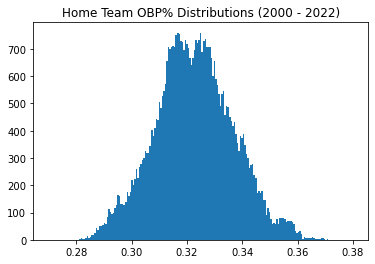

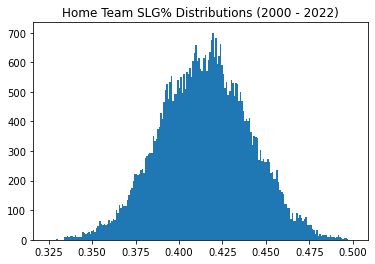

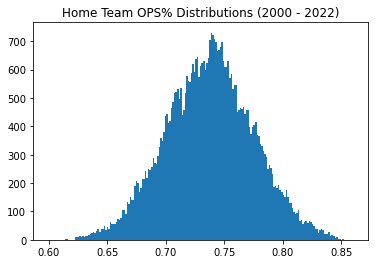

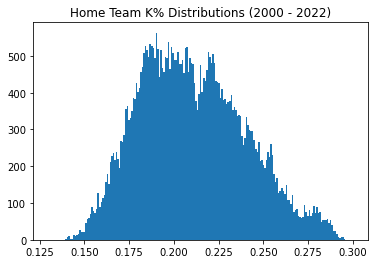

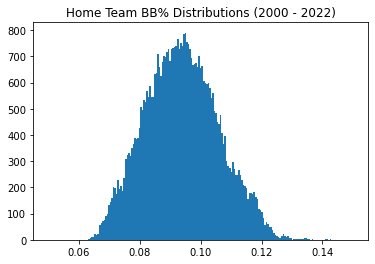

In [19]:
plt.hist(X_train.OBP_162_h, np.linspace(.27,.38,200));
# plt.hist(X_train.OBP_162_v, np.linspace(.26,.38,151));
plt.title('Home Team OBP% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.SLG_162_h, np.linspace(.325,.5,200));
plt.title('Home Team SLG% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.OPS_162_h, np.linspace(.6,.86,200));
plt.title('Home Team OPS% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.SO_perc_162_h, np.linspace(.13,.3,200));
plt.title('Home Team K% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.BB_perc_162_h, np.linspace(.05,.15,200));
plt.title('Home Team BB% Distributions (2000 - 2022)')
plt.show()

In [20]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=500, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

: 

In [19]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [20]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6830520795456688, 0.6905459938835579)

In [21]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

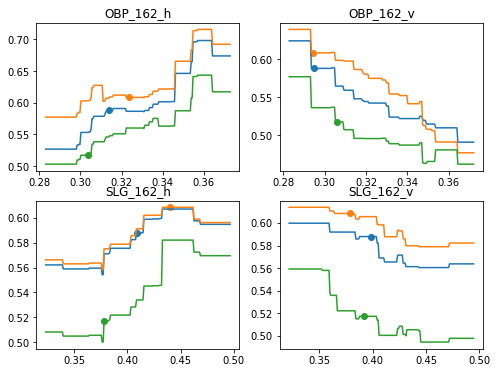

In [22]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

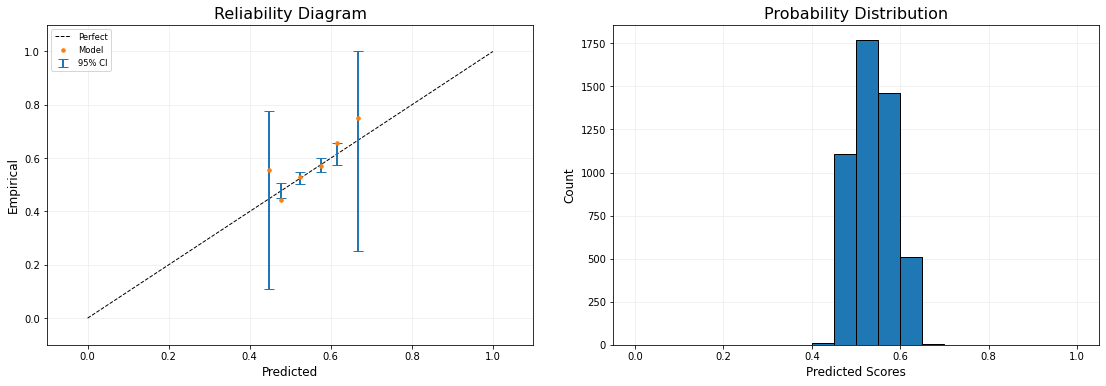

In [23]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [24]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6904403794776431
i=10, eval_set_loss = 0.6890885969363065
i=20, eval_set_loss = 0.6880556272451712
i=30, eval_set_loss = 0.6868293632138979
i=40, eval_set_loss = 0.6855562619813504
i=50, eval_set_loss = 0.6846532691787243
i=60, eval_set_loss = 0.6838440597168504
i=70, eval_set_loss = 0.6833060440839908
i=80, eval_set_loss = 0.6828283365951463
i=90, eval_set_loss = 0.682399232281737
i=100, eval_set_loss = 0.6819061710692358
i=110, eval_set_loss = 0.6816920753427138
i=120, eval_set_loss = 0.6815139388707893
i=130, eval_set_loss = 0.6811554337171607
i=140, eval_set_loss = 0.6811136594072106
i=150, eval_set_loss = 0.6808942542725454
i=160, eval_set_loss = 0.6807008511319772
i=170, eval_set_loss = 0.68056594192578
i=180, eval_set_loss = 0.680463899602746
i=190, eval_set_loss = 0.6802714391649303
i=200, eval_set_loss = 0.6800738074398047
i=210, eval_set_loss = 0.679953066932063
i=220, eval_set_loss = 0.6799594093861896
i=230, eval_set_loss = 0.6800252082182703
i=240, e

In [25]:
preds_stb = stb1.predict(X_test)

In [26]:
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6830149893771823, 0.6905459938835579)

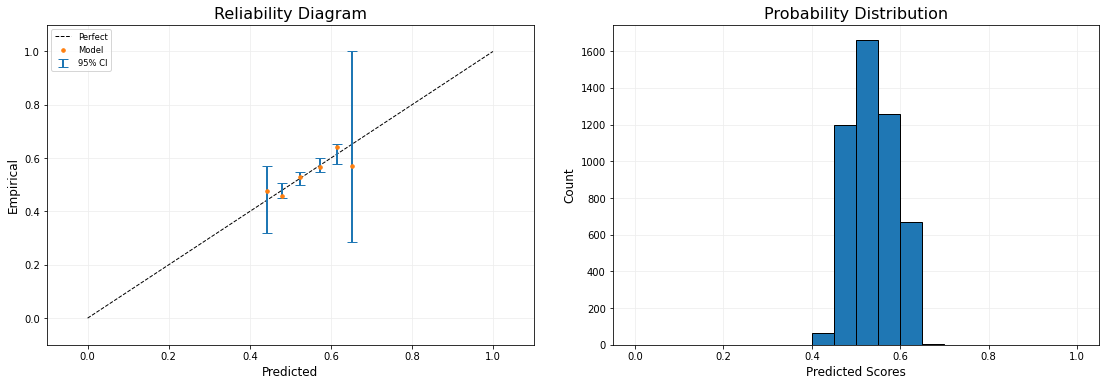

In [27]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

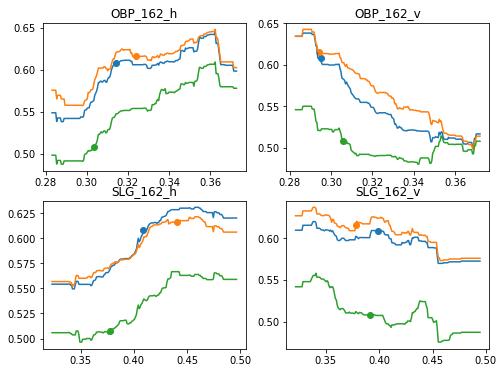

In [28]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=2)